<h1 align="center">Projet Final MDI 721 : Analyse du Vendée Globe 2020 - 2021</h1>
<h3 align="right"><i><br>Roland SCHWARTZ</br>MS IA - 2021/2022</i></h3>

## Import des librairies utiles au projet

In [1]:
import os
import re

import requests
from bs4 import BeautifulSoup

import xlwings as xw

from IPython.display import display, Image
from ipyleaflet import Map, Marker, AntPath, basemaps

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Extraction des données

### Download des fichiers Excel sur l'intégralité de la course

In [2]:
res = requests.get('https://www.vendeeglobe.org/fr/classement')
res.status_code

200

In [3]:
res = requests.get('https://www.vendeeglobe.org/fr/classement')
soup = BeautifulSoup(res.content, 'html.parser')

excel_app = xw.App(visible=False)
dir_excel = 'dir_excel//'

options = soup.find("select").find_all("option")

for option in options[1:-2]:
    tag_xl = option.attrs['value']+'.xlsx'
    url_xl = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+tag_xl
    r_xl = requests.get(url_xl)
    open(dir_excel+tag_xl, 'wb').write(r_xl.content)
    excel_book = excel_app.books.open(dir_excel+tag_xl)
    excel_book.save()
    excel_book.close()

excel_app.quit()


### Récupération et aggrégation des informations sur les bateaux & skippers

In [4]:
res_nav = requests.get('https://www.vendeeglobe.org/fr/glossaire')
res_nav.status_code

200

In [5]:
soup_nav = BeautifulSoup(res_nav.content, 'html.parser')

spec_boat_all = soup_nav.find_all(class_="sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6")

list_spec = []

for spec_boat in spec_boat_all:
    row = {}
    row['Skipper'] = spec_boat.find('span').text
    row['Nom du bateau'] = spec_boat.find('h3').text

    for spec in spec_boat.find_all("li"):
        row[spec.text.split(' : ')[0]] = spec.text.split(' : ')[1]

    url_skipper = 'https://www.vendeeglobe.org'+spec_boat.find(class_='boats-list__popup-skipper-link')['href']

    res_skipper = requests.get(url_skipper)
    soup_skipper = BeautifulSoup(res_skipper.content, 'html.parser')

    row['Nationalité du Skipper'] = soup_skipper.find(class_="skipper-datalist__item m--nationality").find(class_="skipper-datalist__value__text").text
    row['Age du Skipper'] = soup_skipper.find(class_="icon icon-calendar").find_parent("p").find(class_="skipper-datalist__value__text").text.split()[0]
    row['Nb. participations du Skipper au Vendée'] = int(soup_skipper.find(class_="skipper-participation__number").find("span").text)
    
    skipper_all_palmares = soup_skipper.find_all(class_='prizes-slider__year')
    cpt_palma = 0
    for year in skipper_all_palmares:
        list_palma_y = year.find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
        cpt_palma += len(list_palma_y) - 1
    
    row['Nb. Palmarès du Skipper'] = cpt_palma

    row['URL Page Skipper'] = url_skipper
    row['URL Photo Skipper'] = 'https://www.vendeeglobe.org'+soup_skipper.find(class_='skipper-hero__figure__img svg-filter').image['xlink:href']
    row['URL Icône bateau'] = 'https://www.vendeeglobe.org'+spec_boat.find('img')['src']

    list_spec.append(row)

df_boat = pd.DataFrame(list_spec)
df_boat.head()



,Skipper,Nom du bateau,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,...,Voile quille,Surface de voiles au près,Surface de voiles au portant,Nationalité du Skipper,Age du Skipper,Nb. participations du Skipper au Vendée,Nb. Palmarès du Skipper,URL Page Skipper,URL Photo Skipper,URL Icône bateau
0,Fabrice AMEDEO,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,monotype,320 m2,570 m2,FR,43,2,18,https://www.vendeeglobe.org/fr/skippers/93/fab...,https://www.vendeeglobe.org/medias/05/02/50238...,https://www.vendeeglobe.org/medias/05/08/50821...
1,Romain ATTANASIO,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",...,acier forgé,280 m2,560 m2,FR,44,2,12,https://www.vendeeglobe.org/fr/skippers/110/ro...,https://www.vendeeglobe.org/medias/05/03/50390...,https://www.vendeeglobe.org/medias/05/06/50663...
2,Alexia BARRIER,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",...,acier,260 m2,580 m2,FR,41,1,19,https://www.vendeeglobe.org/fr/skippers/100/al...,https://www.vendeeglobe.org/medias/05/06/50614...,https://www.vendeeglobe.org/medias/05/04/50477...
3,Yannick BESTAVEN,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",...,acier mécano soudé,310 m2,550 m2,FR,48,2,17,https://www.vendeeglobe.org/fr/skippers/91/yan...,https://www.vendeeglobe.org/medias/05/05/50512...,https://www.vendeeglobe.org/medias/05/08/50815...
4,Jérémie BEYOU,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",...,acier,320 m2,600 m2,FR,45,4,26,https://www.vendeeglobe.org/fr/skippers/103/je...,https://www.vendeeglobe.org/medias/05/50/55058...,https://www.vendeeglobe.org/medias/05/04/50486...


## Préparation des données

### Nettoyage et formatage des données Skipper

In [8]:
def str2float(str_XL):
    #return float(re.findall(pattern='[-+]?\d*[\.|,]\d+|\d+', string=str_XL.replace(',','.'))[0])
    if (str_XL is None or len(str_XL) == 0):
        floatconv = None
    else:
        #print(str_XL)
        floatconv = float(re.search(pattern='[-+]?\d*[\.|,]\d+|\d+', string=str_XL.replace(',','.')).group(0))
    return floatconv


def dm2float(str_dms):
    if (str_dms is None or len(str_dms) == 0):
        floatconv = None
    else:
        deg, minutes, direction =  re.split('[°\']', str_dms)
        floatconv = (float(deg) + float(minutes)/60) * (-1 if direction in ['W', 'S'] else 1)
    return floatconv

def natsail2int(str_id):
    #return int(re.findall(pattern='\d+', string=str_id)[0])
    if (str_id is None or len(str_id) == 0):
        invconv = None
    else:
        invconv = int(re.search(pattern='\d+', string=str_id).group(0))
    return invconv

str_XL = '554m'
str_XL = ''
print(f'var conv : {str2float(str_XL)} de type : {type(str2float(str_XL))}')

#str_dms = df_course_test.iloc[10]['Latitude']
str_dms = '29°28.03\'N'
print(f'var conv : {dm2float(str_dms)} de type : {type(dm2float(str_dms))}')

str_id = '\nFR\nFRA 02'
print(f'var conv : {natsail2int(str_id)} de type : {type(natsail2int(str_id))}')

var conv : None de type : <class 'NoneType'>
var conv : 29.467166666666667 de type : <class 'float'>
var conv : 2 de type : <class 'int'>


### Nettoyage, formatage et aggrégation des données de la course

In [9]:
col_names = ['Rang', 'Numéro Voile', 'Latitude', 'Longitude', 
			'Cap sur 30 min', 'Vitesse sur 30 min (kts)',
			'VMG sur 30 min (kts)', 'Distance sur 30 min (nm)', 
			'Cap depuis dernier classement', 'Vitesse depuis dernier classement (kts)',
			'VMG depuis dernier classement (kts)', 'Distance depuis dernier classement (nm)',
			'Cap sur 24h', 'Vitesse sur 24h (kts)', 'VMG sur 24h (kts)', 'Distance sur 24h (nm)',
			'Distance restante (nm)', 'Distance au premier (nm)']

col_conv = ['Vitesse sur 30 min (kts)', 'VMG sur 30 min (kts)', 'Distance sur 30 min (nm)',
			'Vitesse depuis dernier classement (kts)', 'VMG depuis dernier classement (kts)',
			'Distance depuis dernier classement (nm)', 'Vitesse sur 24h (kts)', 'VMG sur 24h (kts)',
			'Distance sur 24h (nm)', 'Distance restante (nm)', 'Distance au premier (nm)']

dico_conv = dict.fromkeys(col_conv, str2float)
dico_conv.update(dict.fromkeys(['Latitude', 'Longitude'], dm2float))
dico_conv['Numéro Voile'] = natsail2int

In [10]:
# df_course_test = pd.read_excel('./dir_excel/20201114_080000.xlsx')

xl_file_test = '20201125_040000.xlsx'

df_course_test = pd.read_excel('./'+dir_excel+xl_file_test, converters=dico_conv, na_values=['','\n','\\n'], usecols='B,C,F:U', skiprows=5, skipfooter=4, header=None, names=col_names)
#df_course_test = pd.read_excel('./'+dir_excel+xl_file_test, usecols='B,C,F:U', skiprows=5, skipfooter=4, header=None, names=col_names)
# df_course_test[col_conv].str.extract('[-+]?\d*[\.|,]\d+|\d+')



df_course_test.tail(10)

,Rang,Numéro Voile,Latitude,Longitude,Cap sur 30 min,Vitesse sur 30 min (kts),VMG sur 30 min (kts),Distance sur 30 min (nm),Cap depuis dernier classement,Vitesse depuis dernier classement (kts),VMG depuis dernier classement (kts),Distance depuis dernier classement (nm),Cap sur 24h,Vitesse sur 24h (kts),VMG sur 24h (kts),Distance sur 24h (nm),Distance restante (nm),Distance au premier (nm)
23,24,2,-4.564333,-33.487000,190°,16.4,13.4,8.2,191°,15.2,12.6,106.4,196°,13.0,10.6,312.2,21081.5,2058.7
24,25,72,3.068333,-28.367667,203°,10.1,8.1,5.0,202°,5.6,4.6,38.9,200°,5.3,4.6,128.0,21416.3,2393.5
25,26,56,2.900167,-29.423167,236°,1.1,0.4,0.6,203°,2.3,1.8,16.2,183°,3.9,3.7,93.2,21421.6,2398.8
26,27,50,3.204000,-28.508333,181°,2.8,2.7,1.4,196°,5.1,4.5,36.0,179°,4.7,4.6,112.1,21426.2,2403.3
27,28,83,3.564667,-27.868167,222°,9.3,5.5,4.7,198°,3.8,3.3,26.5,171°,4.1,4.1,99.1,21438.9,2416.0
28,29,222,4.194833,-27.828833,225°,8.0,4.4,4.0,212°,3.6,2.6,24.9,190°,3.3,3.1,79.6,21475.4,2452.6
29,30,69,4.691167,-28.781500,195°,6.6,5.8,3.3,186°,6.2,5.8,43.1,201°,1.5,1.3,36.5,21516.8,2494.0
30,31,11,6.991667,-28.896167,175°,6.9,6.9,3.5,177°,6.7,6.6,46.7,167°,3.2,3.2,76.4,21653.0,2630.2
31,32,8,14.488833,-22.069000,272°,10.3,1.7,5.1,198°,7.5,7.5,52.8,201°,8.5,8.4,204.1,22084.5,3061.6
32,RET,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Présentation synthétique des duos Skipper / IMOCA

## Analyse des données de la course

### VMG vs. Vitesse réelle

### Expérience des skippers et performance

### Caractéristiques de l'IMOCA et performance

# BROUILLON TO REMOVE

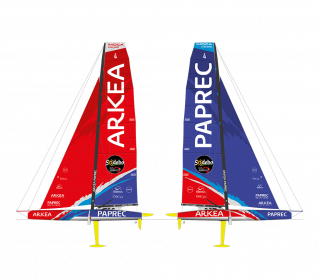

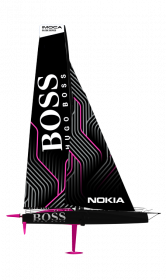

In [11]:
display(Image(df_boat.loc[28]['URL Icône bateau']), Image(df_boat.loc[30]['URL Icône bateau']))

url_test = df_boat.loc[25]['url_skipper']


res_skipper = requests.get(url_test)
soup_skipper = BeautifulSoup(res_skipper.content, 'html.parser')


skipper_nat = soup_skipper.find(class_="skipper-datalist__item m--nationality").find(class_="skipper-datalist__value__text").text
print(f'Nationalité : {skipper_nat}')

skipper_age = soup_skipper.find(class_="icon icon-calendar").find_parent("p").find(class_="skipper-datalist__value__text").text.split()[0]
print(f'Age : {skipper_age}')

skipper_particip = soup_skipper.find(class_="skipper-participation__number").find("span").text
print(f'Nb. participations : {skipper_particip}')

palma_an = '2018'
skipper_palmares = soup_skipper.find(class_='prizes-slider__year',text=palma_an).find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
print(f'Palmares {palma_an} : {len(skipper_palmares)-1} trophées - {skipper_palmares}')

skipper_all_palmares = soup_skipper.find_all(class_='prizes-slider__year')

cpt_palma = 0
for year in skipper_all_palmares:
    list_palma_y = year.find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
    cpt_palma += len(list_palma_y) - 1

print(f'Palmares total : {cpt_palma} trophées')



url_img_skipper = soup_skipper.find(class_='skipper-hero__figure__img svg-filter').image['xlink:href']
print(f'URL image skipper : {url_img_skipper}')


In [15]:
list_xl_files = os.listdir('./'+dir_excel)

#sublist_xl = list_xl_files[100:400]
sublist_xl = list_xl_files[:482]

locations_test = np.zeros([len(sublist_xl),2])
idx = 0

for xl_file in sublist_xl:
    #print(f'reading : {xl_file} ')
    df_loc_test = pd.read_excel('./'+dir_excel+xl_file, usecols='B,C,F:U', skiprows=5, skipfooter=4, header=None, names=col_names, converters=dico_conv)
    df_loc_test.set_index('Numéro Voile', inplace=True)
    locations_test[idx] = [df_loc_test.loc[59]['Latitude'], df_loc_test.loc[59]['Longitude']]
    idx += 1
    if idx%100 == 0:
        print(f'Avancement : {idx} / {len(sublist_xl)}')



Avancement : 100 / 482
Avancement : 200 / 482
Avancement : 300 / 482
Avancement : 400 / 482


In [16]:
# list_locations_test = locations_test.tolist()


In [17]:
import copy

#center = (21.828669, -170.965253)
center = (locations_test[150,0], locations_test[150,1])

locations_test_modif = copy.deepcopy(locations_test)
#locations_test_modif[locations_test_modif[:1]<0] += 180

map_ant = Map(basemap=basemaps.Esri.NatGeoWorldMap, center=center, zoom=3, dragging=True, world_copy_jump=True)

ant_path = AntPath(
    locations=locations_test_modif.tolist(),
    dash_array=[1, 20],
    delay=200,
    color='#030aa7',
    pulse_color='#d7fffe',
    weight=7
)

map_ant.add_layer(ant_path)

display(map_ant)

Map(center=[-38.39516666666667, 32.809333333333335], controls=(ZoomControl(options=['position', 'zoom_in_text'…